<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/evaluate_sipgate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 501 (delta 151), reused 147 (delta 74), pack-reused 267 (from 1)
Receiving objects: 100% (501/501), 227.01 KiB | 1.09 MiB/s, done.
Resolving deltas: 100% (310/310), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.read_datasets import read_sipgate_dataset
from bin.utils.clean_sipgate_dataset import clean_sipgate_dataset
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
def calculate_mean_metrics(results):
    # Initialize dictionaries to store sums and counts
    metric_sums = {}
    metric_counts = {}

    # Process each intent dictionary
    for intent_dict in results:
        for intent_name, data in intent_dict.items():
            results = data["results"]
            for metric, value in results.items():
                if np.isnan(value):
                    continue
                metric_sums[metric] = metric_sums.get(metric, 0) + value
                metric_counts[metric] = metric_counts.get(metric, 0) + 1

    # Calculate means
    mean_metrics = {
        metric: round(metric_sums[metric] / metric_counts[metric], 2)
        for metric in metric_sums
    }

    return mean_metrics

In [6]:
def results_to_dataframe(results: list[dict]):
    # Initialize an empty DataFrame
    columns = ["intent"] + list(list(results[0].values())[0]["results"].keys())
    df = pd.DataFrame(columns=columns)
    df.set_index("intent", inplace=True)

    # Process each intent dictionary
    for intent_dict in results:
        for intent_name, data in intent_dict.items():
            results = data["results"]
            df.loc[intent_name] = results

    df["intent"] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [28]:
def plot_results_df(df: pd.DataFrame, plot_func=plt.hist):
    # make a dashboard of plots
    # where each plot is the distribution of a metric
    # across all intents
    n_metrics = len([col for col in df.columns if not df[col].isnull().all()]) - 1
    n_cols = 2
    n_rows = n_metrics // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axs = axs.flatten()

    for i, metric in enumerate(df.columns[1:]):
        if metric == "intent" or df[metric].isnull().all():
            continue

        x, y = df[metric].index, df[metric].values

        ax = axs[i]
        sns.swarmplot(
            data=y,
            ax=ax,
            color="blue",
            alpha=0.5,
            linewidth=0,
        )
        ax.set_title(metric)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

In [9]:
df = read_sipgate_dataset()
df = clean_sipgate_dataset(df)
print(df.head())

                                                text                  intent
0  ich habe mich per email bei ihnen gemeldet all...     account_verify_info
1  ich möchte meine rufnummer zu einem anderen an...        porting_fallback
2                                   warum aktivieren     account_verify_info
3  die portierung funktioniert nicht was mache ic...        porting_rejected
4                               brief nicht erhalten  account_verify_no_code


In [10]:
from bin.framework.metrics import Metric
metrics = [
    Metric.DISTINCT_1,
    Metric.DISTINCT_2,
    Metric.TTR,
    Metric.MOVING_AVERAGE_TTR,
    Metric.AVERAGE_N_OF_TOKENS,
    Metric.AVERAGE_N_OF_CHARACTERS,
    Metric.DISTANCE_TO_CENTROID,
    Metric.INTER_SENTENCE_SIMILARITY,
    Metric.BLEU,
    Metric.MEAN_LEVENSHTEIN_DISTANCE,
    Metric.POS_TAG_N_GRAMS_DIVERSITY,
]

In [11]:
framework = Framework(metrics=metrics)
results = framework.apply_framework_to_datasets(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

 19%|█▉        | 70/370 [05:25<16:13,  3.25s/it]WARNING:bin.framework.framework:No data found for intent nan. Skipping evaluation.


No data found for intent nan. Skipping evaluation.


100%|██████████| 370/370 [18:38<00:00,  3.02s/it]


In [12]:
print(results)
results_df = results_to_dataframe(results)

[{'account_verify_info': {'results': {'distinct_1': 0.333, 'distinct_2': 0.752, 'ttr': 0.98, 'moving_average_ttr': 0.0, 'average_n_of_tokens': 7.896, 'average_n_of_characters': 51.783, 'centroid_distance': 0.699, 'inter_sentence_similarity': 0.49}}}, {'porting_fallback': {'results': {'distinct_1': 0.431, 'distinct_2': 0.896, 'ttr': 0.961, 'moving_average_ttr': 0.0, 'average_n_of_tokens': 12.083, 'average_n_of_characters': 84.375, 'centroid_distance': 0.746, 'inter_sentence_similarity': 0.429}}}, {'porting_rejected': {'results': {'distinct_1': 0.255, 'distinct_2': 0.719, 'ttr': 0.986, 'moving_average_ttr': 0.0, 'average_n_of_tokens': 9.795, 'average_n_of_characters': 70.85, 'centroid_distance': 0.744, 'inter_sentence_similarity': 0.436}}}, {'account_verify_no_code': {'results': {'distinct_1': 0.158, 'distinct_2': 0.507, 'ttr': 0.983, 'moving_average_ttr': 0.0, 'average_n_of_tokens': 9.656, 'average_n_of_characters': 60.752, 'centroid_distance': 0.689, 'inter_sentence_similarity': 0.506}

     distinct_1  distinct_2    ttr  moving_average_ttr  average_n_of_tokens  \
0         0.333       0.752  0.980                 0.0                7.896   
1         0.431       0.896  0.961                 0.0               12.083   
2         0.255       0.719  0.986                 0.0                9.795   
3         0.158       0.507  0.983                 0.0                9.656   
4         0.309       0.697  0.991                 0.0                5.897   
..          ...         ...    ...                 ...                  ...   
364       0.889       1.000  1.000                 0.0                4.500   
365       0.578       0.818  1.000                 0.0                3.000   
366       0.441       0.841  0.953                 0.0               13.900   
367       1.000       1.000  1.000                 0.0               10.000   
368       1.000       1.000  1.000                 0.0                3.000   

     average_n_of_characters  centroid_distance  in

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 84.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 84.6% of the points cannot be plac

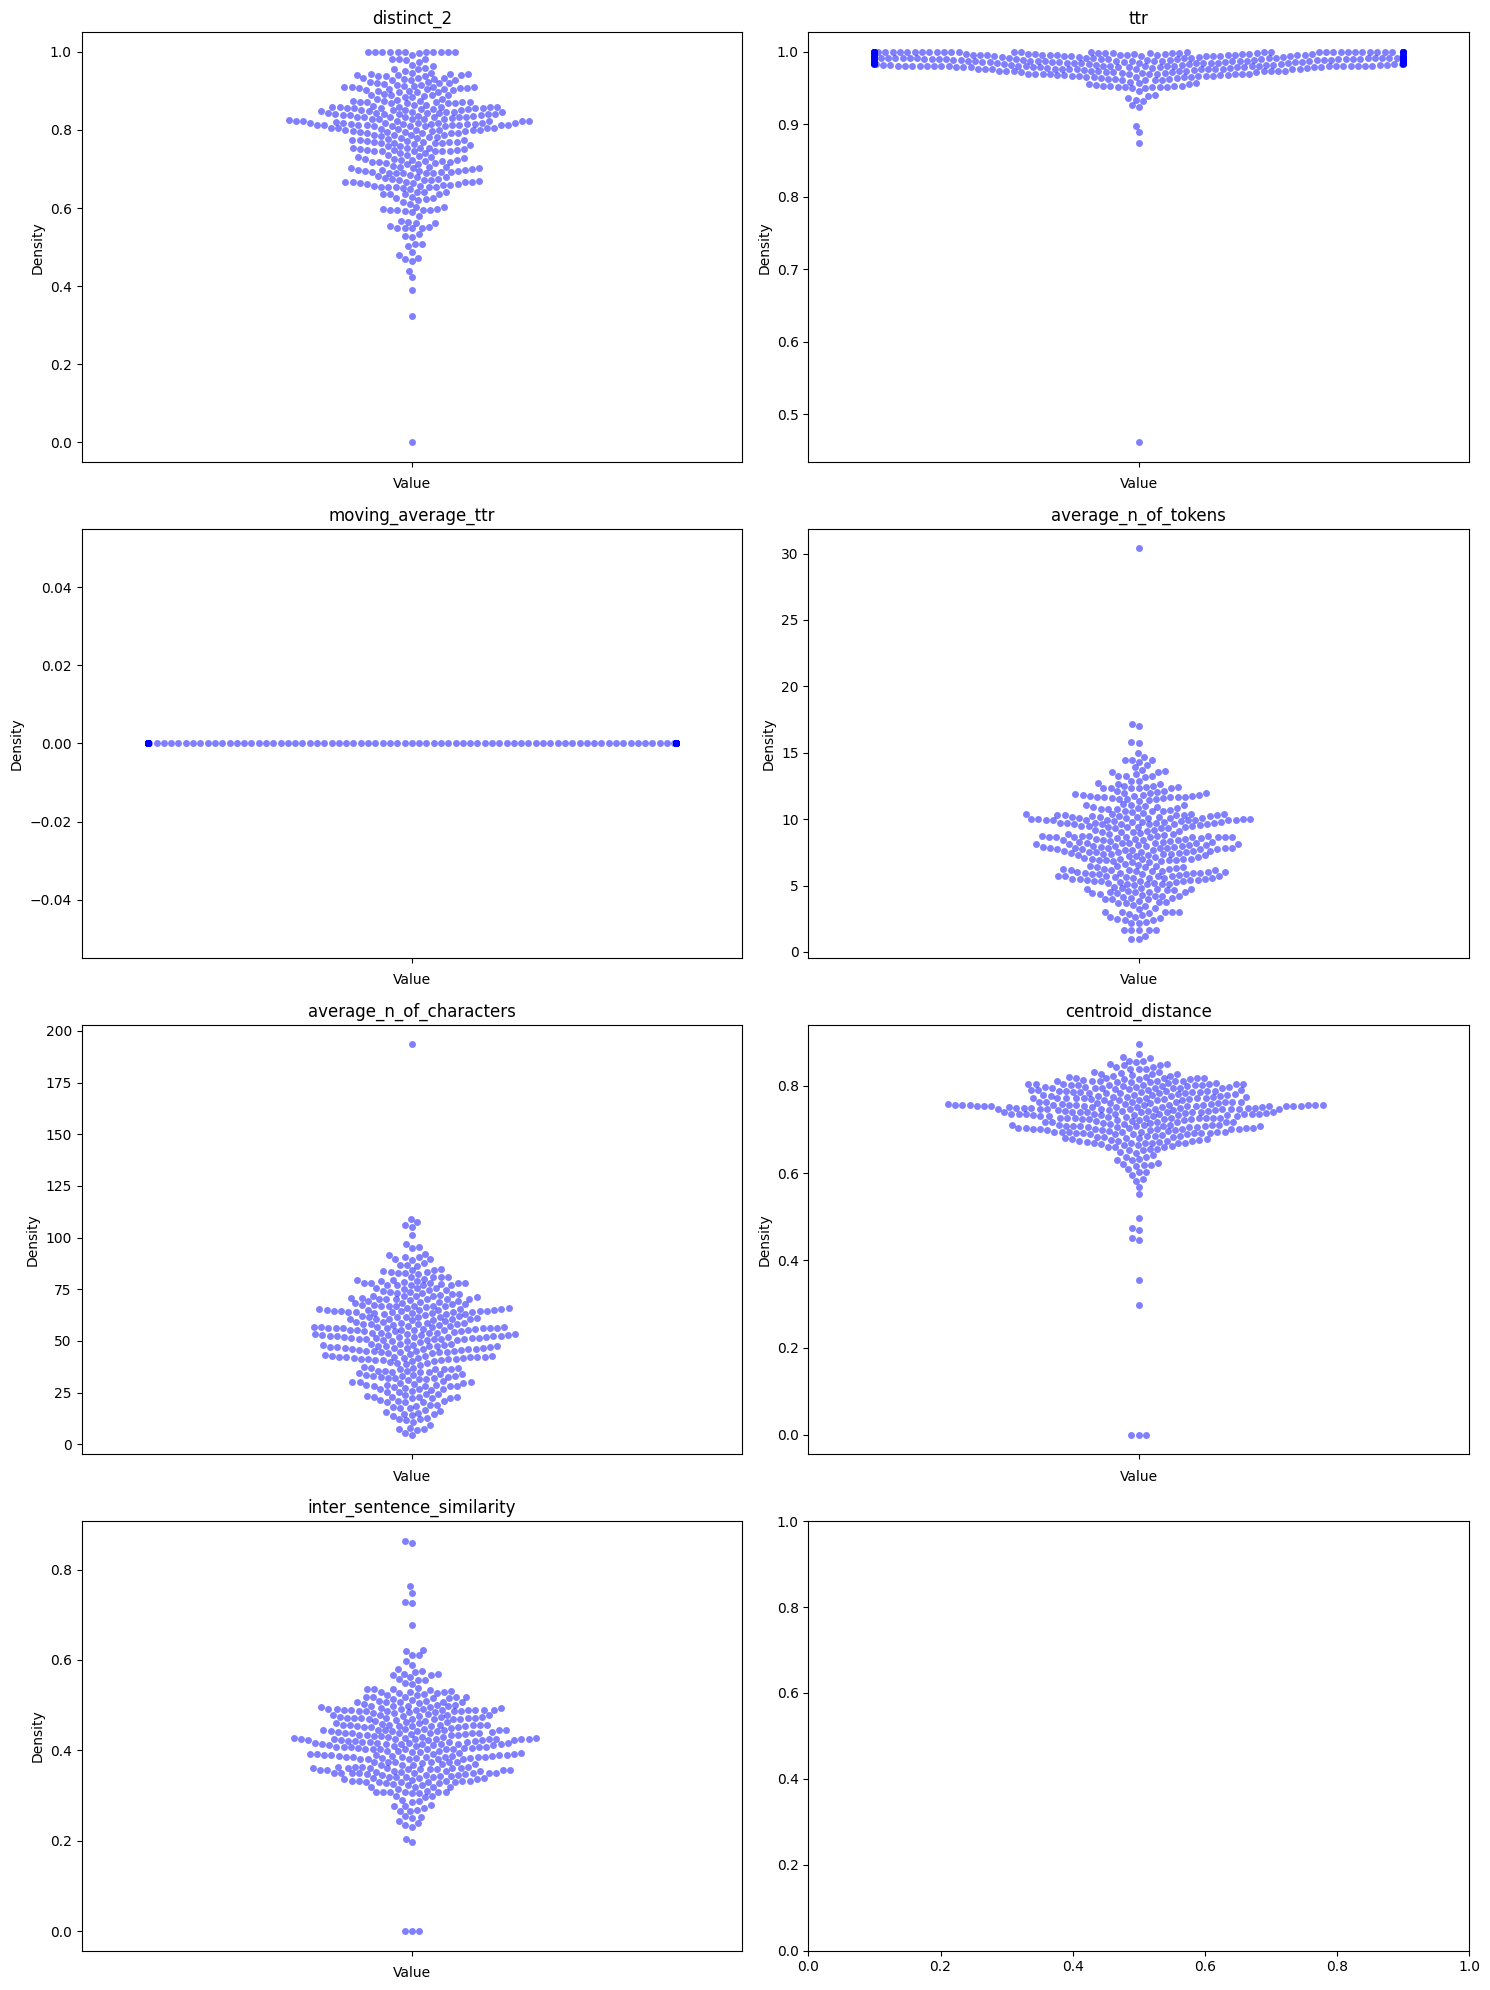

In [29]:
print(results_df)
plot_results_df(results_df)